**Necessary imports**

In [1]:
import os
import wrds
import pandas as pd
import warnings
from datetime import datetime, timedelta
import numpy as np
from functools import reduce
warnings.filterwarnings("ignore")

**STEP 1 : data collection from wrds**

In [ ]:
user_name = os.getenv('WRDS_USERNAME')
db = wrds.Connection(wrds_username=user_name)

In [ ]:
#---------------------------------------------
# Risk Free Rate 
#---------------------------------------------
Rf=db.raw_sql("""select  mcaldt,tmytm 
           from crsp.tfz_mth_rf            
            where kytreasnox = 2000001 
           and mcaldt>='2002-03-01'
            and mcaldt<='2024-12-31'""", date_cols=['mcaldt'])
Rf['tmytm']=Rf['tmytm']/12/100


Rf=Rf.rename(columns={ "mcaldt": "date","tmytm": "rf"})
Rf['date'] = Rf['date'].dt.to_period('M').dt.to_timestamp('M') 
Rf.set_index('date', inplace = True)

#Get the crsp value-weighted return index
query_crsp = """select  date,vwretd from crsp.msi 
                where date>='2002-03-01' and date<='2024-12-31'"""

crsp_returns = db.raw_sql(query_crsp,  date_cols=['date'])
crsp_returns = crsp_returns.rename(columns={'vwretd': 'us_return'})
crsp_returns.to_csv('data/crsp_return.csv')
Rf.to_csv('data/t_bills_one_month.csv')

In [2]:
Rf = pd.read_csv('data/t_bills_one_month.csv')
Rf.set_index('date', inplace = True)
Rf.index = pd.to_datetime(Rf.index)

In [3]:
crsp_returns = pd.read_csv('data/crsp_return.csv')
crsp_returns = crsp_returns.drop(columns= 'Unnamed: 0')#D'ou ca vient ???
crsp_returns['date'] = pd.to_datetime(crsp_returns['date'])
crsp_returns['date'] = crsp_returns['date'].dt.to_period('M').dt.to_timestamp('M') 

In [4]:
from dateutil.relativedelta import relativedelta
#Interest Rates: 3-Month or 90-Day Rates and Yields: Interbank Rates
def load_and_prepare_ir3(filepath, rename_dict):
    df = pd.read_csv(filepath).rename(columns=rename_dict)
    df['date'] = pd.to_datetime(df['date'])    
    df['date'] = df['date'] - pd.DateOffset(months=1)
    df['date'] = df['date'].dt.to_period('M').dt.to_timestamp('M') 
    df[df.columns[1]] /= 100
    return df.set_index('date')                 

# Load each series using the helper
ir3_japan = load_and_prepare_ir3("data/IR3TIB01JPM156N.csv", {"observation_date": "date", "IR3TIB01JPM156N": "ir3_jpn"})
ir3_fra   = load_and_prepare_ir3("data/IR3TIB01FRM156N.csv", {"observation_date": "date", "IR3TIB01FRM156N": "ir3_fra"})
ir3_gb    = load_and_prepare_ir3("data/IR3TIB01GBM156N.csv", {"observation_date": "date", "IR3TIB01GBM156N": "ir3_gb"})
ir3_us    = load_and_prepare_ir3("data/IR3TIB01USM156N.csv", {"observation_date": "date", "IR3TIB01USM156N": "ir3_us"})
ir3_aus   = load_and_prepare_ir3("data/IR3TIB01AUM156N.csv", {"observation_date": "date", "IR3TIB01AUM156N": "ir3_aus"})
ir3_ch    = load_and_prepare_ir3("data/IR3TIB01CHM156N.csv", {"observation_date": "date", "IR3TIB01CHM156N": "ir3_ch"})
ir3_deu   = load_and_prepare_ir3("data/IR3TIB01DEM156N.csv", {"observation_date": "date", "IR3TIB01DEM156N": "ir3_deu"})



# JPY: DEXJPUS (JPY per 1 USD) 
df_jpy = pd.read_csv("data/EXJPUS.csv").rename(columns={"observation_date": "date"})

df_jpy.name = "JPY_per_USD"

# CHF: DEXSZUS (CHF per 1 USD)
df_chf = pd.read_csv("data/EXSZUS.csv").rename(columns={"observation_date": "date"})
df_chf.name = "CHF_per_USD"

# AUD: DEXUSAL (USD per 1 AUD) 
df_aud = pd.read_csv("data/EXUSAL.csv").rename(columns={"observation_date": "date"})
df_aud["AUD_per_USD"] = 1 / df_aud["EXUSAL"]


# EUR: DEXUSEU (USD per 1 EUR) 
df_eur = pd.read_csv("data/EXUSEU.csv").rename(columns={"observation_date": "date"})
df_eur["EUR_per_USD"] = 1 / df_eur["EXUSEU"]

# GBP: DEXUSUK (USD per 1 GBP) 
df_gbp = pd.read_csv("data/EXUSUK.csv").rename(columns={"observation_date": "date"})
df_gbp["GBP_per_USD"] = 1 / df_gbp["EXUSUK"]

files = {
    'jpn': 'data/jpn.csv',
    'aus': 'data/aus.csv',
    'deu': 'data/deu.csv',
    'fra': 'data/fra.csv',
    'ch':  'data/swz.csv',
    'gb':  'data/uk.csv'
}

country_data = {}

for code, path in files.items():
    df = pd.read_csv(path)
    df['date'] = pd.to_datetime(df['date'])
    df['date'] = df['date'].dt.to_period('M').dt.to_timestamp('M') 
 
    return_col = [col for col in df.columns if col != 'date'][0]
    df = df.rename(columns={return_col: f'{code}_return'})
    country_data[code] = df



In [5]:
foreign_to_usd = pd.concat([
    df_jpy['EXJPUS'].rename("JPY_per_USD"),
    df_chf['EXSZUS'].rename("CHF_per_USD"),
    df_aud['AUD_per_USD'].rename("AUD_per_USD"),
    df_eur['EUR_per_USD'].rename("EUR_per_USD"),
    df_gbp['GBP_per_USD'].rename("GBP_per_USD")
], axis=1)
index = pd.to_datetime(df_jpy['date'])- pd.DateOffset(months=1)
foreign_to_usd.index =  index.dt.to_period('M').dt.to_timestamp('M') 

In [6]:
foreign_to_usd

,JPY_per_USD,CHF_per_USD,AUD_per_USD,EUR_per_USD,GBP_per_USD
date,,,,,
2002-02-28,131.0610,1.6743,1.902588,1.140771,0.702741
2002-03-31,130.7718,1.6542,1.868460,1.128668,0.693049
2002-04-30,126.3750,1.5889,1.818843,1.090513,0.685025
2002-05-31,123.2905,1.5399,1.759944,1.045916,0.673991
2002-06-30,117.8991,1.4718,1.805706,1.006543,0.642467
...,...,...,...,...,...
2024-07-31,146.2641,0.8579,1.501953,0.907441,0.772499
2024-08-31,142.9540,0.8472,1.477105,0.900576,0.756487
2024-09-30,149.8909,0.8613,1.492537,0.917852,0.766695


In [7]:
1/foreign_to_usd

,JPY_per_USD,CHF_per_USD,AUD_per_USD,EUR_per_USD,GBP_per_USD
date,,,,,
2002-02-28,0.007630,0.597265,0.5256,0.8766,1.4230
2002-03-31,0.007647,0.604522,0.5352,0.8860,1.4429
2002-04-30,0.007913,0.629366,0.5498,0.9170,1.4598
2002-05-31,0.008111,0.649393,0.5682,0.9561,1.4837
2002-06-30,0.008482,0.679440,0.5538,0.9935,1.5565
...,...,...,...,...,...
2024-07-31,0.006837,1.165637,0.6658,1.1020,1.2945
2024-08-31,0.006995,1.180359,0.6770,1.1104,1.3219
2024-09-30,0.006672,1.161036,0.6700,1.0895,1.3043


**Visualizing the data**

<Figure size 800x400 with 0 Axes>

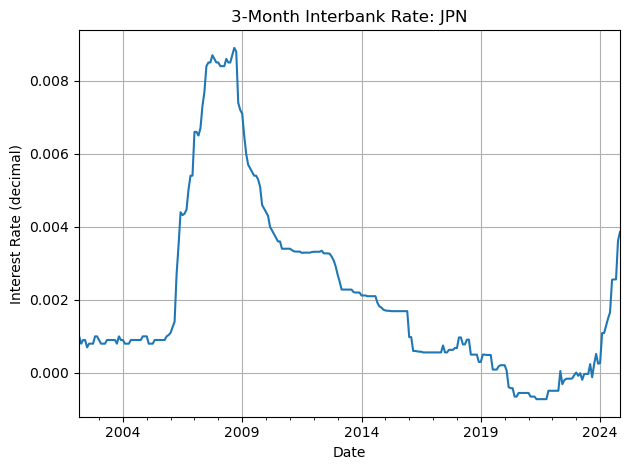

<Figure size 800x400 with 0 Axes>

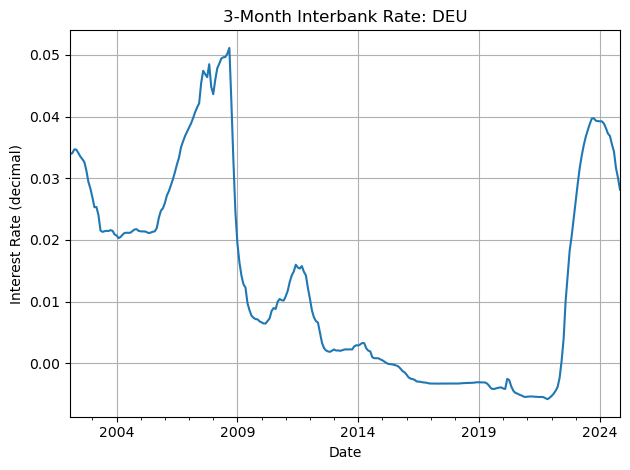

<Figure size 800x400 with 0 Axes>

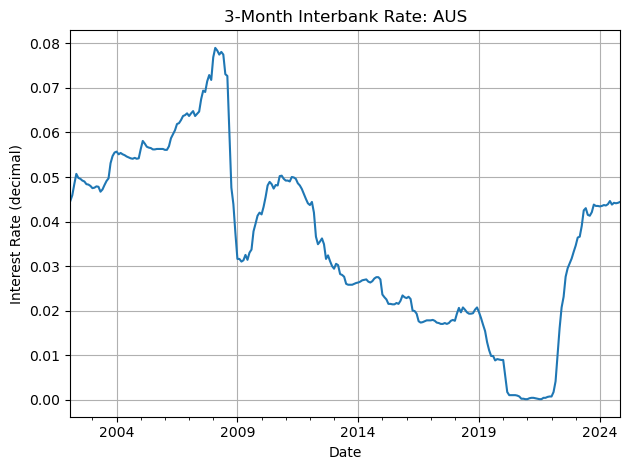

<Figure size 800x400 with 0 Axes>

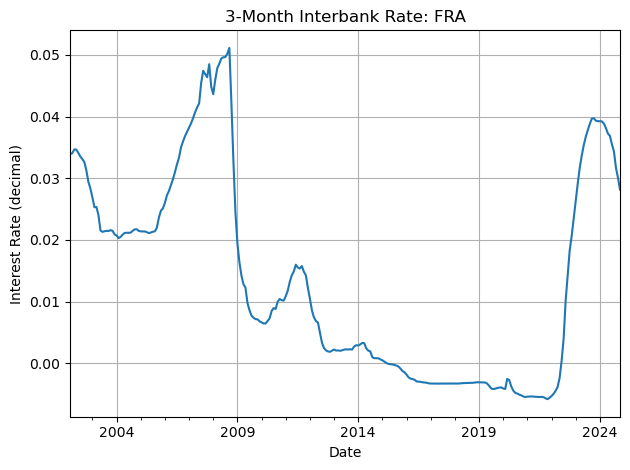

<Figure size 800x400 with 0 Axes>

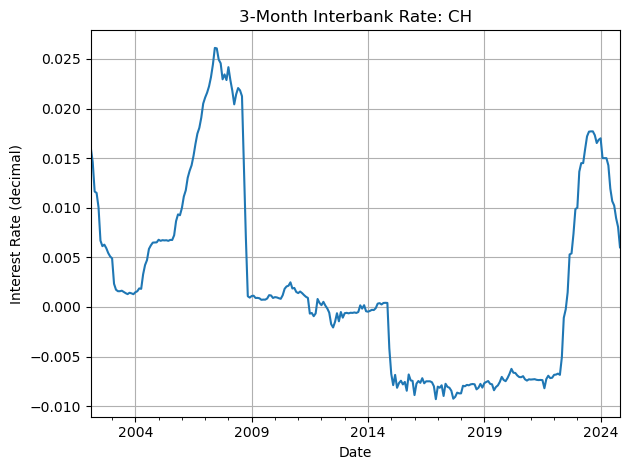

<Figure size 800x400 with 0 Axes>

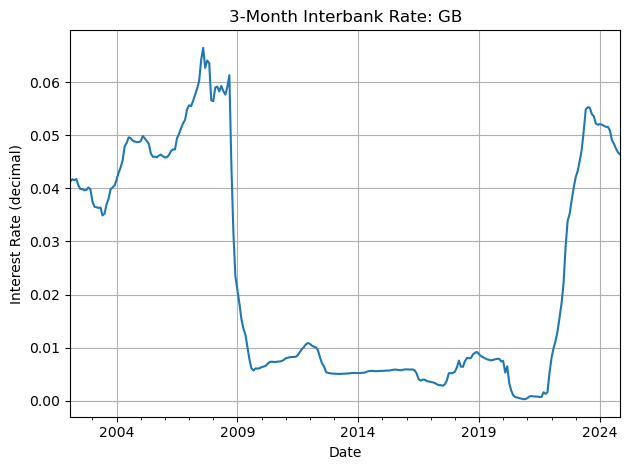

<Figure size 800x400 with 0 Axes>

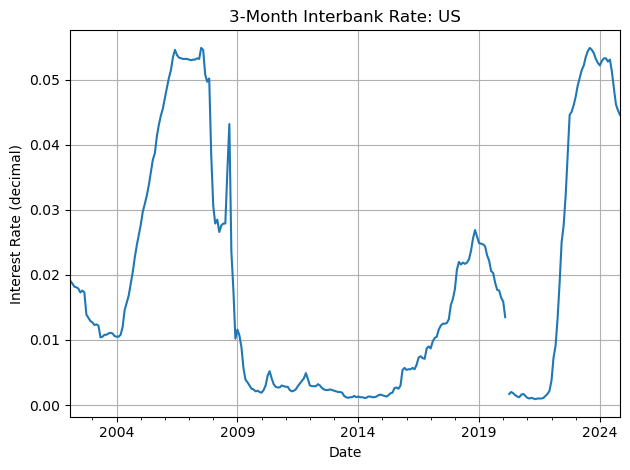

In [8]:
import matplotlib.pyplot as plt
ir3_data = {
    'jpn': ir3_japan,
    'deu': ir3_deu,
    'aus': ir3_aus,
    'fra': ir3_fra,
    'ch': ir3_ch,
    'gb': ir3_gb,
    'us' : ir3_us
}

for country, df in ir3_data.items():
    plt.figure(figsize=(8, 4))
    df.plot(y=f'ir3_{country}', legend=False)
    plt.title(f'3-Month Interbank Rate: {country.upper()}')
    plt.xlabel('Date')
    plt.ylabel('Interest Rate (decimal)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

**We observe a missing value in 2020 for the us interbank rate, to replace it we will use interpolation**

In [9]:
ir3_data['us'] = ir3_us.interpolate(method='time')

<Axes: xlabel='date'>

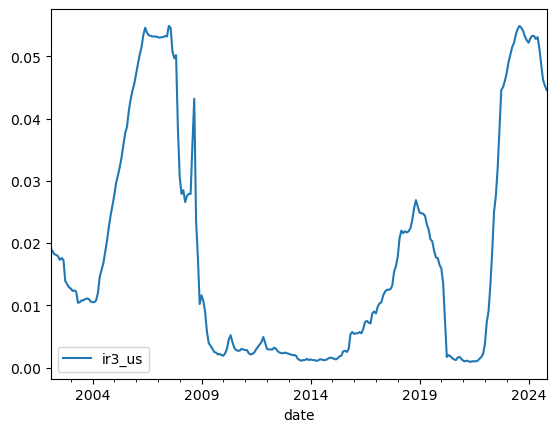

In [10]:
ir3_data['us'].plot()

**Now it is interpolated, and all our data is continuous ! **

In [11]:
#Merge all the interbank together 
ir3_all = pd.concat(
    [df.rename(columns={df.columns[0]: f'ir3_{code}'}) for code, df in ir3_data.items()],
    axis=1,
    join='outer'
)
ir3_all = ir3_all.dropna()

**Let's plot the exchange rate**

<Figure size 1000x400 with 0 Axes>

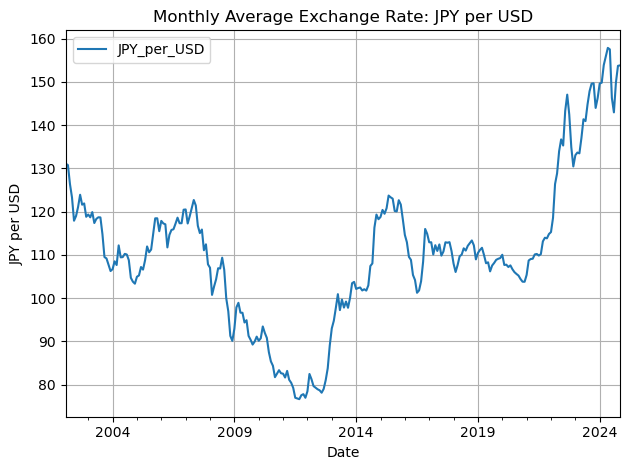

<Figure size 1200x600 with 0 Axes>

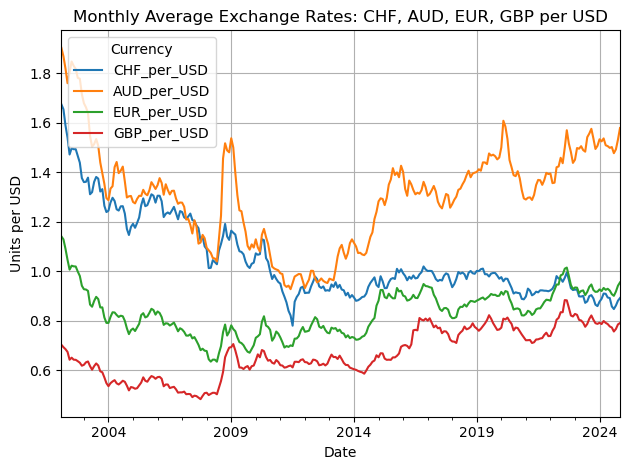

In [12]:
# Separate JPY from others
monthly_jpy = foreign_to_usd[['JPY_per_USD']]
monthly_others = foreign_to_usd.drop(columns='JPY_per_USD')


plt.figure(figsize=(10, 4))
monthly_jpy.plot()
plt.title("Monthly Average Exchange Rate: JPY per USD")
plt.xlabel("Date")
plt.ylabel("JPY per USD")
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
monthly_others.plot()
plt.title("Monthly Average Exchange Rates: CHF, AUD, EUR, GBP per USD")
plt.xlabel("Date")
plt.ylabel("Units per USD")
plt.grid(True)
plt.legend(title="Currency", loc="upper left")
plt.tight_layout()
plt.show()

### Unhedged Dollar Return from Foreign Investment

Let:

- \( X_t \) be the **exchange rate** at time \( t \), expressed in **USD per unit of foreign currency** (e.g., USD per EUR).
- \( P_t \) be the **foreign currency price** of the foreign stock market (including dividends), denominated in **foreign currency**.

Then the **unhedged dollar return** \( R_{\text{noh}} \) of \$1 invested in the foreign stock market is:

$$
R_{\text{noh}} = \frac{P_{t+1} \cdot X_{t+1}}{P_t \cdot X_t} - 1
$$

### Units

| Symbol     | Description                                | Units                     |
|------------|--------------------------------------------|---------------------------|
| \( X_t \)   | Exchange rate (USD per 1 foreign currency) | USD/FX                    |
| \( P_t \)   | Foreign stock index (cum dividends)        | FX (foreign currency)     |
| \( P_t X_t \) | Dollar value of the investment            | USD                       |


In [13]:
usd_to_foreign = 1 / foreign_to_usd
usd_to_foreign.columns = [f'USD_PER_{col.split("_")[0]}' for col in usd_to_foreign.columns]

In [14]:
usd_to_foreign

,USD_PER_JPY,USD_PER_CHF,USD_PER_AUD,USD_PER_EUR,USD_PER_GBP
date,,,,,
2002-02-28,0.007630,0.597265,0.5256,0.8766,1.4230
2002-03-31,0.007647,0.604522,0.5352,0.8860,1.4429
2002-04-30,0.007913,0.629366,0.5498,0.9170,1.4598
2002-05-31,0.008111,0.649393,0.5682,0.9561,1.4837
2002-06-30,0.008482,0.679440,0.5538,0.9935,1.5565
...,...,...,...,...,...
2024-07-31,0.006837,1.165637,0.6658,1.1020,1.2945
2024-08-31,0.006995,1.180359,0.6770,1.1104,1.3219
2024-09-30,0.006672,1.161036,0.6700,1.0895,1.3043


In [15]:
def convert_foreign_to_usd(ret_foreign_currency, ret_fx):
    return (1 + ret_foreign_currency) * (1 + ret_fx) - 1

# Step 1: Compute FX returns
ret_exchange_rate = usd_to_foreign / usd_to_foreign.shift(1) -1
ret_exchange_rate.dropna(inplace=True)
ret_exchange_rate.sort_index(inplace=True)


def process_country(df, fx_column, ret_exchange_rate):
    df = df[['date', 'country', 'mportret']].copy()
    df.dropna(subset=['mportret'], inplace=True)

    # Merge on date to align
    df = df.merge(ret_exchange_rate[[fx_column]], how='inner', left_on='date', right_index=True)

    # Convert to USD returns
    df['mportret'] = convert_foreign_to_usd(df['mportret'], df[fx_column])
    df = df[['date', 'country', 'mportret']]
    return df


jpn = process_country(country_data['jpn'], 'USD_PER_JPY', ret_exchange_rate)
aus = process_country(country_data['aus'], 'USD_PER_AUD', ret_exchange_rate)
deu = process_country(country_data['deu'], 'USD_PER_EUR', ret_exchange_rate)
fra = process_country(country_data['fra'], 'USD_PER_EUR', ret_exchange_rate)
ch  = process_country(country_data['ch'],  'USD_PER_CHF', ret_exchange_rate)
gb  = process_country(country_data['gb'],  'USD_PER_GBP', ret_exchange_rate)


crsp_returns['country'] = 'US'
crsp_returns.rename(columns={'us_return': 'mportret'}, inplace=True)
us = crsp_returns[['date', 'country', 'mportret']].copy()
us = us.dropna().iloc[1:-1]  # Drop first and last row

# Combine all
merged_all = pd.concat([jpn, aus, deu, fra, ch, gb, us], axis=0, ignore_index=True)


In [16]:
merged_all['date'] = pd.to_datetime(merged_all['date'])
merged_all['date'] = merged_all['date'].dt.to_period('M').dt.to_timestamp('M')

**PROBLEM WITH AUStralia We neED to find what. The following is to see why** 

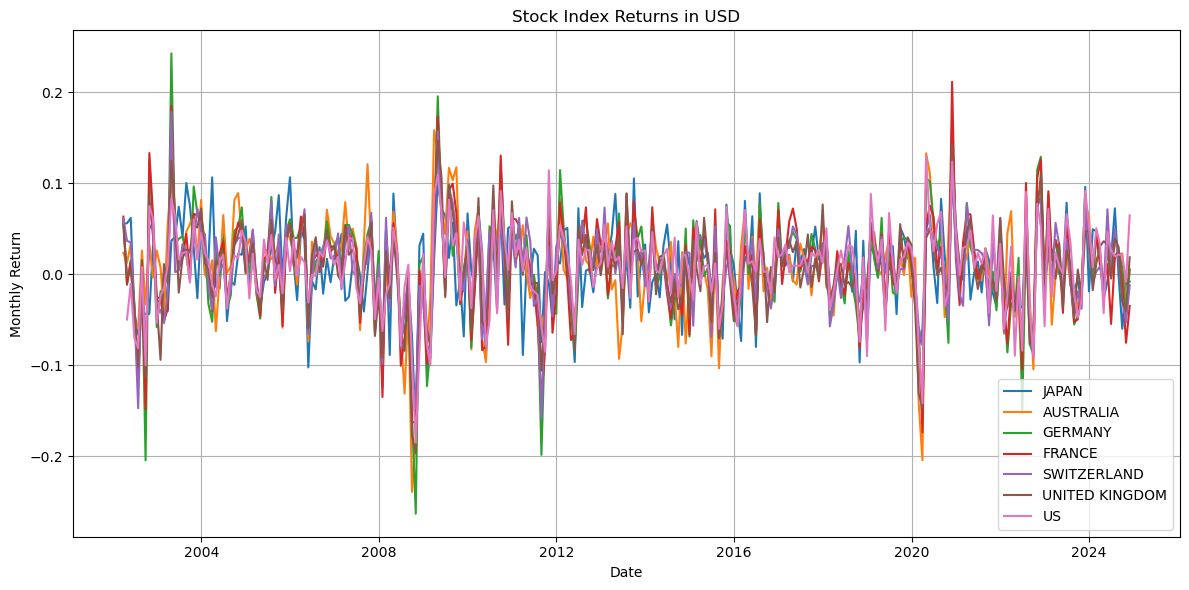

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for country in merged_all['country'].unique():
    subset = merged_all[merged_all['country'] == country]
    plt.plot(subset['date'], subset['mportret'], label=country)

plt.title('Stock Index Returns in USD')
plt.xlabel('Date')
plt.ylabel('Monthly Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
import matplotlib.pyplot as plt

def compare_countries(merged_all, country1, country2, return_type='mportret'):
    """
    Plot cumulative returns in USD of two countries from the merged_all dataframe.
    
    Parameters:
        merged_all (DataFrame): Combined dataset with 'date', 'country', and return columns.
        country1, country2 (str): Country names to compare (must match 'country' column values).
        return_type (str): Either 'mportret' (unhedged) or 'mportretx' (hedged).
    """
    df1 = merged_all[merged_all['country'] == country1][['date', return_type]].copy()
    df2 = merged_all[merged_all['country'] == country2][['date', return_type]].copy()

    # Merge on date to ensure strict alignment
    df = df1.merge(df2, on='date', suffixes=(f'_{country1}', f'_{country2}'))

    # Compute cumulative returns
    df[f'cumulative_{country1}'] = (1 + df[f'{return_type}_{country1}']).cumprod()
    df[f'cumulative_{country2}'] = (1 + df[f'{return_type}_{country2}']).cumprod()

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df['date'], df[f'cumulative_{country1}'], label=country1, linewidth=2)
    plt.plot(df['date'], df[f'cumulative_{country2}'], label=country2, linewidth=2)
    plt.title(f'Cumulative Return in USD: {country1} vs {country2}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return (Start = 1)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


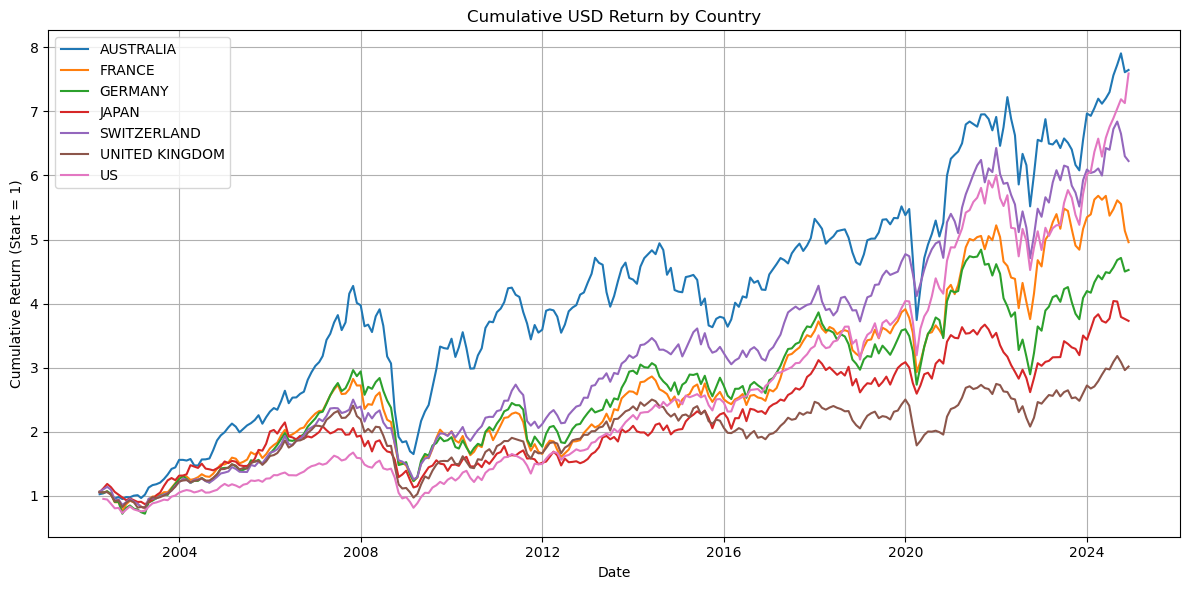

In [19]:
merged_all_filtered = merged_all[merged_all['date'] > '2002-01-01']

plt.figure(figsize=(12, 6))

# Plot cumulative returns for each country
for country, group in merged_all_filtered.groupby('country'):
    cumulative = (1 + group['mportret']).cumprod()
    plt.plot(group['date'], cumulative, label=country)

plt.title('Cumulative USD Return by Country')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (Start = 1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Currency-Hedged Excess Return in USD

The formula for the **excess return** in USD from a $1 investment in the Euro-currency hedged via shorting the foreign currency is:

$$
X_{t+1}^{\text{EU}} = \frac{S_{t+1}}{S_t}(1 + r^{\text{EU}}) - (1 + r^{\text{US}})
$$

Where:

- \( X_{t+1}^{\text{EU}} \): Excess return in USD from the currency-hedged investment in the Euro-currency  
- \( S_t \): Spot exchange rate at time \( t \), in USD per EUR  
- \( S_{t+1} \): Spot exchange rate at time \( t+1 \), in USD per EUR  
- \( r^{\text{EU}} \): Risk-free interest rate in the Eurozone over the period  
- \( r^{\text{US}} \): Risk-free interest rate in the US over the period  


Get USD per euro 

In [20]:
foreign_to_usd

,JPY_per_USD,CHF_per_USD,AUD_per_USD,EUR_per_USD,GBP_per_USD
date,,,,,
2002-02-28,131.0610,1.6743,1.902588,1.140771,0.702741
2002-03-31,130.7718,1.6542,1.868460,1.128668,0.693049
2002-04-30,126.3750,1.5889,1.818843,1.090513,0.685025
2002-05-31,123.2905,1.5399,1.759944,1.045916,0.673991
2002-06-30,117.8991,1.4718,1.805706,1.006543,0.642467
...,...,...,...,...,...
2024-07-31,146.2641,0.8579,1.501953,0.907441,0.772499
2024-08-31,142.9540,0.8472,1.477105,0.900576,0.756487
2024-09-30,149.8909,0.8613,1.492537,0.917852,0.766695


In [21]:
usd_to_foreign.drop(index=['2002-03-31', '2002-04-30'], inplace=True)

In [22]:
proportion = usd_to_foreign.shift(-1) / usd_to_foreign
proportion = proportion.dropna()


ir3_filtered = ir3_all.iloc[:-1]  


excess_return = pd.DataFrame({
    'JAPAN': proportion['USD_PER_JPY'] * (1 + ir3_filtered['ir3_jpn']) - (1 + ir3_filtered['ir3_us']),
    'FRANCE': proportion['USD_PER_EUR'] * (1 + ir3_filtered['ir3_fra']) - (1 + ir3_filtered['ir3_us']),
    'GERMANY': proportion['USD_PER_EUR'] * (1 + ir3_filtered['ir3_deu']) - (1 + ir3_filtered['ir3_us']),
    'AUSTRALIA': proportion['USD_PER_AUD'] * (1 + ir3_filtered['ir3_aus']) - (1 + ir3_filtered['ir3_us']),
    'SWITZERLAND': proportion['USD_PER_CHF'] * (1 + ir3_filtered['ir3_ch']) - (1 + ir3_filtered['ir3_us']),
    'UNITED KINGDOM': proportion['USD_PER_GBP'] * (1 + ir3_filtered['ir3_gb']) - (1 + ir3_filtered['ir3_us'])
})
excess_return = excess_return.iloc[2:] 


hedge_return = pd.DataFrame()
countries = ['JAPAN', 'FRANCE', 'GERMANY', 'AUSTRALIA', 'SWITZERLAND', 'UNITED KINGDOM']

for c in countries:
    df = merged_all[merged_all['country'] == c].copy()
    df = df.set_index('date')  


    excess = excess_return[c]

    # Align both on index intersection
    aligned_df, aligned_excess = df.align(excess, join='inner', axis=0)

    hedge_return[c] = aligned_df['mportret'] - aligned_excess


In [23]:
usd_to_foreign

,USD_PER_JPY,USD_PER_CHF,USD_PER_AUD,USD_PER_EUR,USD_PER_GBP
date,,,,,
2002-02-28,0.007630,0.597265,0.5256,0.8766,1.4230
2002-05-31,0.008111,0.649393,0.5682,0.9561,1.4837
2002-06-30,0.008482,0.679440,0.5538,0.9935,1.5565
2002-07-31,0.008404,0.667913,0.5413,0.9781,1.5368
2002-08-31,0.008259,0.669748,0.5465,0.9806,1.5563
...,...,...,...,...,...
2024-07-31,0.006837,1.165637,0.6658,1.1020,1.2945
2024-08-31,0.006995,1.180359,0.6770,1.1104,1.3219
2024-09-30,0.006672,1.161036,0.6700,1.0895,1.3043


In [24]:
foreign_to_usd

,JPY_per_USD,CHF_per_USD,AUD_per_USD,EUR_per_USD,GBP_per_USD
date,,,,,
2002-02-28,131.0610,1.6743,1.902588,1.140771,0.702741
2002-03-31,130.7718,1.6542,1.868460,1.128668,0.693049
2002-04-30,126.3750,1.5889,1.818843,1.090513,0.685025
2002-05-31,123.2905,1.5399,1.759944,1.045916,0.673991
2002-06-30,117.8991,1.4718,1.805706,1.006543,0.642467
...,...,...,...,...,...
2024-07-31,146.2641,0.8579,1.501953,0.907441,0.772499
2024-08-31,142.9540,0.8472,1.477105,0.900576,0.756487
2024-09-30,149.8909,0.8613,1.492537,0.917852,0.766695


In [25]:
ir3_all

,ir3_jpn,ir3_deu,ir3_aus,ir3_fra,ir3_ch,ir3_gb,ir3_us
date,,,,,,,
2002-03-31,0.00100,0.034069,0.0459,0.034069,0.014606,0.041732,0.0187
2002-04-30,0.00080,0.034671,0.0484,0.034671,0.011635,0.041537,0.0182
2002-05-31,0.00090,0.034640,0.0507,0.034640,0.011496,0.041776,0.0181
2002-06-30,0.00090,0.034100,0.0498,0.034100,0.010031,0.040605,0.0179
2002-07-31,0.00070,0.033519,0.0496,0.033519,0.006683,0.039865,0.0173
...,...,...,...,...,...,...,...
2024-07-31,0.00255,0.035476,0.0438,0.035476,0.010665,0.049100,0.0512
2024-08-31,0.00256,0.034337,0.0442,0.034337,0.010221,0.048400,0.0486
2024-09-30,0.00256,0.031666,0.0441,0.031666,0.008945,0.047500,0.0462


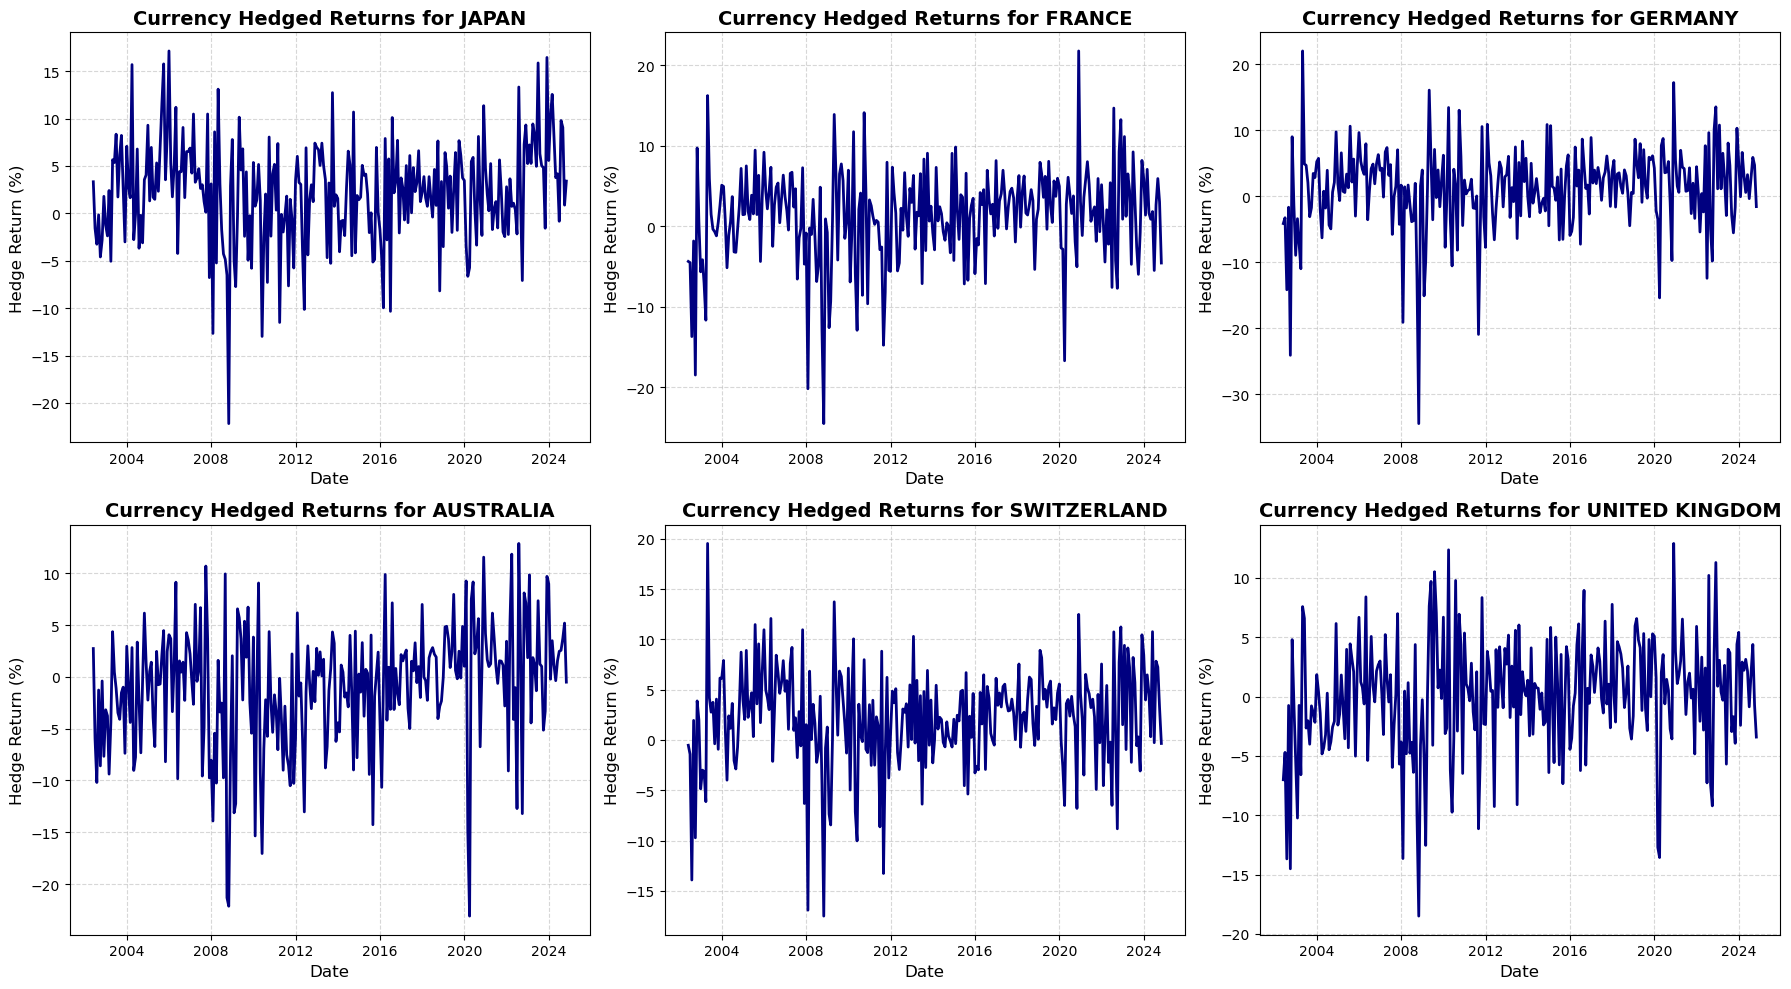

In [26]:
import matplotlib.pyplot as plt


countries = hedge_return.columns[:6] 
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  
axes = axes.flatten()  

for i, country in enumerate(countries):
    ax = axes[i]
    ax.plot(hedge_return[country] * 100, color='navy', linewidth=2)
    ax.set_title(f'Currency Hedged Returns for {country.upper()}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Hedge Return (%)', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.5)


for j in range(len(countries), 6):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [27]:
hedge_return.to_csv('data/q3/hedge_return.csv')

In [28]:
hedge_return.columns

Index(['JAPAN', 'FRANCE', 'GERMANY', 'AUSTRALIA', 'SWITZERLAND',
       'UNITED KINGDOM'],
      dtype='object')

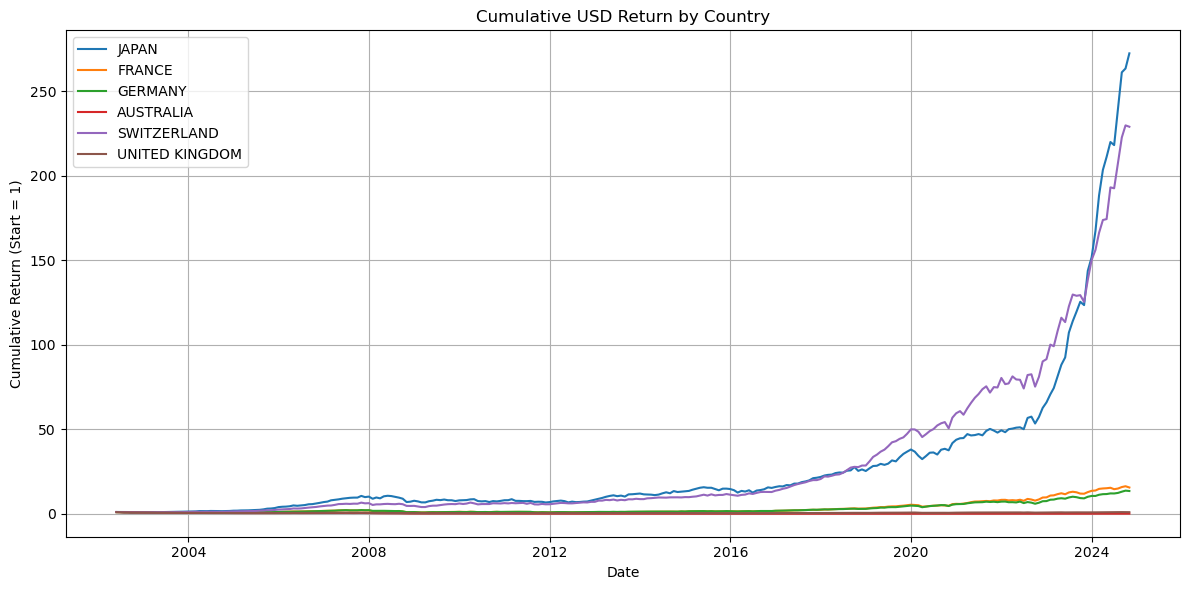

In [29]:
plt.figure(figsize=(12, 6))

# Plot cumulative returns for each country
for country in hedge_return.columns:
    cumulative = (1 + hedge_return[country]).cumprod()
    plt.plot(hedge_return.index, cumulative, label=country)

plt.title('Cumulative USD Return by Country')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (Start = 1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**C** •Equal weight the indexes No currency hedging

In [30]:
def evaluate_strategy_performance(strategy_return: pd.Series, Rf: pd.Series, name: str = "Strategy", zero_cost = False):
    """
    Evaluate the performance of a strategy vs. the risk-free rate.
    
    Parameters:
    - strategy_return: pd.Series of monthly strategy returns (e.g., equal-weighted)
    - Rf: pd.Series of monthly risk-free rate (same units)
    - name: Optional name to use in the output
    """
    strategy_return = strategy_return.dropna()

    # Align both series
    common_dates = strategy_return.index.intersection(Rf.index)

    aligned_strategy = strategy_return.loc[common_dates]
    aligned_rf = Rf.loc[common_dates]
    
    # Compute excess returns
    if zero_cost : 
        excess_return = aligned_strategy.values
    else : 
        excess_return = aligned_strategy.values - aligned_rf.values
    mean_excess = excess_return.mean()
    std_excess = excess_return.std()
    sharpe_annualized = (mean_excess / std_excess) * np.sqrt(12)

    print("-" * 50)
    print(f"Performance Summary for: {name}")
    print(f"Mean Monthly Excess Return   : {mean_excess:.5f}")
    print(f"Standard Deviation (Monthly) : {std_excess:.5f}")
    print(f"Annualized Sharpe Ratio      : {sharpe_annualized:.3f}")
    print("-" * 50)

In [31]:
pivoted = merged_all.pivot(index='date', columns='country', values='mportret')

equal_weight = pivoted.mean(axis=1)

In [32]:
evaluate_strategy_performance(equal_weight, Rf, name="Equal Weight Strategy")


--------------------------------------------------
Performance Summary for: Equal Weight Strategy
Mean Monthly Excess Return   : 0.00604
Standard Deviation (Monthly) : 0.04395
Annualized Sharpe Ratio      : 0.476
--------------------------------------------------


In [33]:
currency_dollar_strategy = excess_return.mean(axis=1)
evaluate_strategy_performance(currency_dollar_strategy, Rf, 'Currency dollar Strategy')

--------------------------------------------------
Performance Summary for: Currency dollar Strategy
Mean Monthly Excess Return   : -0.00428
Standard Deviation (Monthly) : 0.02239
Annualized Sharpe Ratio      : -0.662
--------------------------------------------------


**C** •Equal weight the indexes currency hedging

In [34]:
equal_weight_hedged = hedge_return.mean(axis=1)
evaluate_strategy_performance(equal_weight_hedged, Rf,name = "Equal Weight Hedged Return Strategy")

--------------------------------------------------
Performance Summary for: Equal Weight Hedged Return Strategy
Mean Monthly Excess Return   : 0.00871
Standard Deviation (Monthly) : 0.04867
Annualized Sharpe Ratio      : 0.620
--------------------------------------------------


**C** •Risk-Parity based on a 60 months rolling window estimate of the strategy returns
volatilities

In [35]:
windowed_std = pivoted.rolling(window=60).std()
windowed_std.dropna(inplace=True)

rp_weights = 1/windowed_std

rp_weights_normalized = rp_weights.div(rp_weights.sum(axis=1), axis=0)


common_dates = pivoted.index.intersection(rp_weights_normalized.index)
aligned_extend_pivoted = pivoted.loc[common_dates]


value_portfolio = aligned_extend_pivoted*rp_weights_normalized

In [36]:
portfolio_returns = value_portfolio.sum(axis=1)

evaluate_strategy_performance(portfolio_returns, Rf,name='Risk parity strategy')

--------------------------------------------------
Performance Summary for: Risk parity strategy
Mean Monthly Excess Return   : 0.00429
Standard Deviation (Monthly) : 0.04428
Annualized Sharpe Ratio      : 0.336
--------------------------------------------------


**C** •Risk-Parity based on a 60 months rolling window estimate of the strategy returns
volatilities with currency hedge

In [37]:
windowed_std_hedge = hedge_return.rolling(window=60).std()
windowed_std_hedge.dropna(inplace=True)


rp_weights_hedge = 1 / windowed_std_hedge


rp_weights_hedge_normalized = rp_weights_hedge.div(rp_weights_hedge.sum(axis=1), axis=0)


common_dates_hedge = hedge_return.index.intersection(rp_weights_hedge_normalized.index)
aligned_extended_pivoted_hedge = hedge_return.loc[common_dates_hedge]

value_portfolio_hedge = aligned_extended_pivoted_hedge * rp_weights_hedge_normalized


In [38]:
div = value_portfolio_hedge .sum(axis=1)

evaluate_strategy_performance(div,  Rf,name='Risk parity strategy with currency hedge')

--------------------------------------------------
Performance Summary for: Risk parity strategy with currency hedge
Mean Monthly Excess Return   : 0.00876
Standard Deviation (Monthly) : 0.04863
Annualized Sharpe Ratio      : 0.624
--------------------------------------------------


**C** •Mean-variance optimal combination based on the rolling window mean and co-
variance matrix

In [ ]:
def compute_tangency(cov_windowed, mean_windowed) : 
    tangency_weights = {}
    risk_aversion = 1
    for date in mean_windowed.index:
        cov = cov_windowed.loc[date].to_numpy()
        mean = mean_windowed.loc[date]
        rf = Rf.loc[date].to_numpy()

        mu_excess = mean - rf  

        #x, *_ = np.linalg.lstsq(cov, mu_excess, rcond=None)

        weights = np.linalg.inv(cov)@(mu_excess)
        

        tangency_weights[date] = pd.Series(weights /risk_aversion, index=mean.index)


    tangency_weights_df = pd.DataFrame(tangency_weights).T
    tangency_weights_df.index.name = 'date'
    tangency_weights_df.columns.name = 'country'



    common_dates = pivoted.index.intersection(tangency_weights_df.index)
    aligned_extend_pivoted = pivoted.loc[common_dates]


    value_portfolio = aligned_extend_pivoted *tangency_weights_df
    tangency_return = value_portfolio .sum(axis=1)

    return tangency_return, tangency_weights_df

In [44]:
mean_windowed = pivoted.rolling(window=60).mean()
cov_windowed  = pivoted.rolling(window=60).cov()

mean_windowed.dropna(inplace=True)
cov_windowed.dropna(inplace=True)


tangency_return, tangency_weights =  compute_tangency(cov_windowed, mean_windowed)

evaluate_strategy_performance(tangency_return , Rf,name='Tangency portfolio without currency hedge')

--------------------------------------------------
Performance Summary for: Tangency portfolio without currency hedge
Mean Monthly Excess Return   : 0.20578
Standard Deviation (Monthly) : 0.48411
Annualized Sharpe Ratio      : 1.473
--------------------------------------------------


<Axes: title={'center': 'MVE portfolio with a risk aversion of 1'}, xlabel='date'>

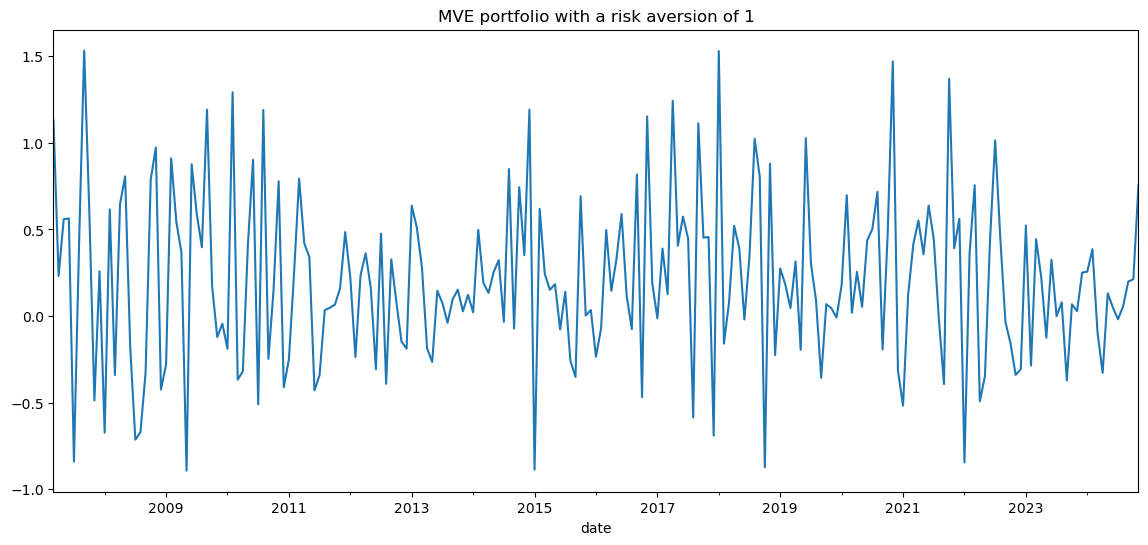

In [46]:

tangency_return.plot(title='MVE portfolio with a risk aversion of 1', figsize=(14, 6))


In [ ]:

mean_windowed = hedge_return.rolling(window=60).mean()
cov_windowed = hedge_return.rolling(window=60).cov()

mean_windowed.dropna(inplace=True)
cov_windowed.dropna(inplace=True)

tangency_return_hedged =  compute_tangency(cov_windowed, mean_windowed)


evaluate_strategy_performance(tangency_return_hedged, Rf, name='Tangency currency hedged strategy')


--------------------------------------------------
Performance Summary for: Tangency currency hedged strategy
Mean Monthly Excess Return   : 0.25177
Standard Deviation (Monthly) : 1.17706
Annualized Sharpe Ratio      : 0.741
--------------------------------------------------


<Axes: title={'center': 'MVE portfolio hedged with a risk aversion of 1'}, xlabel='date'>

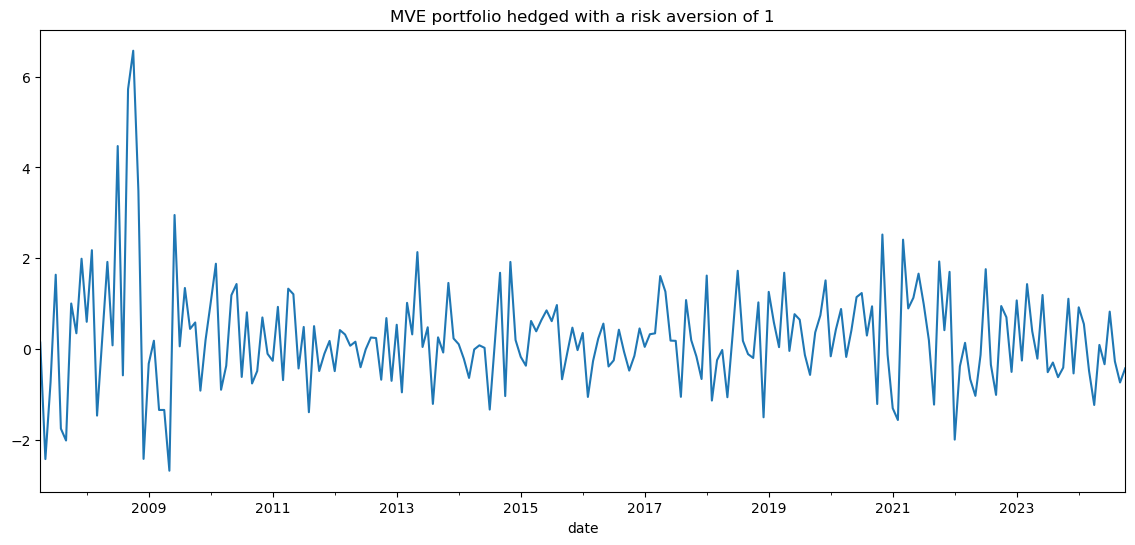

In [ ]:
tangency_return_hedged.plot(title='MVE portfolio hedged with a risk aversion of 1', figsize=(14, 6))

**4 Equity Index Momentum Strategy (MOM)** 

In [ ]:
from scipy import stats
import statsmodels.api as sm

def ranked_based_strategy(lagged, hedged) :
    ranks = lagged.rank(axis=1, method='first')


    N = hedged.shape[1]
    rank_center = (N + 1) / 2

    position = ranks - rank_center

    long = position.where(position > 0, 0)
    short = position.where(position < 0, 0)

    long_weight = long.div(long.sum(axis=1), axis=0)
    short_weight = short.div(short.sum(axis=1), axis=0)


    weights = long_weight.fillna(0) - short_weight.fillna(0)



    common_dates_hedge = hedged.index.intersection(weights.index)
    aligned_extended_pivoted_hedge = hedged.loc[common_dates_hedge]
    weights = weights.loc[common_dates_hedge]

    return aligned_extended_pivoted_hedge * weights, long_weight, short_weight, aligned_extended_pivoted_hedge



def test_mean_nonzero(series, alpha=0.05):
    t_stat, p_value = stats.ttest_1samp(series, 0)

    if p_value < alpha:
        print(f"The strategy average return is significant at alpha = {alpha}, so we can reject the null hypothesis that the mean is 0.")
    else:
        print(f"The strategy average return is not significant at alpha = {alpha}, so we cannot reject the null hypothesis that the mean is 0.")



def ranked_based_strategy_long_short_evaluation(lagged, hedged, Rf, name) :

    strategy, long_weight, short_weight, aligned_extended_pivoted_hedge  = ranked_based_strategy(lagged, hedged)
    strategy = strategy.sum(axis=1)
    evaluate_strategy_performance(strategy, Rf, name=name, zero_cost=True)

    long_leg_strat = aligned_extended_pivoted_hedge * long_weight

    long_leg_strat = long_leg_strat.sum(axis=1)


    evaluate_strategy_performance(long_leg_strat, Rf, name=f'{name} only the Long leg')


    short_leg_strat = aligned_extended_pivoted_hedge * short_weight

    short_leg_strat = short_leg_strat.sum(axis=1)


    evaluate_strategy_performance(short_leg_strat, Rf, name=f'{name} only the Short leg')


    return strategy


def regressed(regressor, dependent) : 
    common_dates = regressor.index.intersection(dependent.index)
    aligned_regressor = regressor.loc[common_dates]
    aligned_dependent = dependent.loc[common_dates]

    y = aligned_dependent
    X = aligned_regressor
    X = sm.add_constant(X) 

    model = sm.OLS(y, X)
    results = model.fit()

    print(results.summary())

        

### Momentum Weight Derivation and Normalization

We define the weight for country \( i \) at time \( t \) as:

$
w_t^i = Z \left( \text{Rank}_t^i - \frac{N + 1}{2} \right)
$



In [ ]:
lagged_return = hedge_return.shift(1).rolling(window=11).apply(lambda x: np.prod(1 + x), raw=True)
lagged_return.dropna(inplace=True)

mom = ranked_based_strategy_long_short_evaluation(lagged_return, hedge_return, Rf, 'Equity Index Momentum Strategy')

--------------------------------------------------
Performance Summary for: Equity Index Momentum Strategy
Mean Monthly Excess Return   : 0.02049
Standard Deviation (Monthly) : 0.03313
Annualized Sharpe Ratio      : 2.142
--------------------------------------------------
--------------------------------------------------
Performance Summary for: Equity Index Momentum Strategy only the Long leg
Mean Monthly Excess Return   : 0.01979
Standard Deviation (Monthly) : 0.04915
Annualized Sharpe Ratio      : 1.395
--------------------------------------------------
--------------------------------------------------
Performance Summary for: Equity Index Momentum Strategy only the Short leg
Mean Monthly Excess Return   : -0.00070
Standard Deviation (Monthly) : 0.05063
Annualized Sharpe Ratio      : -0.048
--------------------------------------------------


In [ ]:
test_mean_nonzero(mom)

The strategy average return is significant at alpha = 0.05, so we can reject the null hypothesis that the mean is 0.


In [ ]:
regressed(div, mom)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.2117
Date:                Sun, 01 Jun 2025   Prob (F-statistic):              0.646
Time:                        17:49:35   Log-Likelihood:                 423.54
No. Observations:                 211   AIC:                            -843.1
Df Residuals:                     209   BIC:                            -836.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0166      0.002      7.245      0.0

The MOM strategy delivers significant positive alpha, meaning it adds return beyond what DIV explains The insignificant beta implies low correlation with DIV hence, there is a diversification benefit.

Combining them may improve the maximum Sharpe ratio of the total portfolio.

**5. Equity Index Long Term Reversal strategy (REV)**

In [ ]:
lagged_return_rev = hedge_return.shift(12).rolling(window=49).apply(lambda x: np.prod(1 + x), raw=True)
lagged_return_rev = lagged_return_rev.dropna()
rev = ranked_based_strategy_long_short_evaluation(lagged_return_rev , hedge_return, Rf, 'Equity Index Long Term Reversal Strategy')

--------------------------------------------------
Performance Summary for: Equity Index Long Term Reversal Strategy
Mean Monthly Excess Return   : 0.01806
Standard Deviation (Monthly) : 0.03268
Annualized Sharpe Ratio      : 1.914
--------------------------------------------------
--------------------------------------------------
Performance Summary for: Equity Index Long Term Reversal Strategy only the Long leg
Mean Monthly Excess Return   : 0.01550
Standard Deviation (Monthly) : 0.04896
Annualized Sharpe Ratio      : 1.097
--------------------------------------------------
--------------------------------------------------
Performance Summary for: Equity Index Long Term Reversal Strategy only the Short leg
Mean Monthly Excess Return   : -0.00256
Standard Deviation (Monthly) : 0.05228
Annualized Sharpe Ratio      : -0.169
--------------------------------------------------


In [ ]:
test_mean_nonzero(rev)

The strategy average return is significant at alpha = 0.05, so we can reject the null hypothesis that the mean is 0.


In [ ]:
regressed(div, rev)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.431
Date:                Sun, 01 Jun 2025   Prob (F-statistic):              0.233
Time:                        17:49:36   Log-Likelihood:                 421.13
No. Observations:                 210   AIC:                            -838.3
Df Residuals:                     208   BIC:                            -831.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0186      0.002      8.075      0.0

A DIV investor should definitely consider allocating to the rev strategy, it provides strong alpha and low correlation with existing exposures.

**6. Currency Carry Strategy (CARRY)**

In [ ]:
ir3_foreign = ir3_all[list(set(ir3_all.columns) - {'ir3_us'})]
ir3_us = ir3_all['ir3_us']


ir3_differential = ir3_foreign.sub(ir3_us, axis=0)
ir3_differential.rename({'ir3_jpn' : 'JAPAN' , 'ir3_deu' : 'GERMANY' , 'ir3_gb' : 'UNITED KINGDOM', 'ir3_ch' : 'SWITZERLAND', 'ir3_fra' : 'FRANCE', 'ir3_aus' : 'AUSTRALIA'}, axis = 1, inplace=True)

lagged_ir3_differential = ir3_differential.shift(1) #To have w_t and X_t+1
carry = ranked_based_strategy_long_short_evaluation(lagged_ir3_differential , excess_return, Rf, 'Carry Strategy') #Here we need to use the currency hedged not the index

--------------------------------------------------
Performance Summary for: Carry Strategy
Mean Monthly Excess Return   : 0.02599
Standard Deviation (Monthly) : 0.02307
Annualized Sharpe Ratio      : 3.902
--------------------------------------------------
--------------------------------------------------
Performance Summary for: Carry Strategy only the Long leg
Mean Monthly Excess Return   : 0.00973
Standard Deviation (Monthly) : 0.02689
Annualized Sharpe Ratio      : 1.254
--------------------------------------------------
--------------------------------------------------
Performance Summary for: Carry Strategy only the Short leg
Mean Monthly Excess Return   : -0.01606
Standard Deviation (Monthly) : 0.02438
Annualized Sharpe Ratio      : -2.282
--------------------------------------------------


In [ ]:
test_mean_nonzero(carry)

The strategy average return is significant at alpha = 0.05, so we can reject the null hypothesis that the mean is 0.


In [ ]:
regressed(div, carry)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                   0.06024
Date:                Sun, 01 Jun 2025   Prob (F-statistic):              0.806
Time:                        17:49:37   Log-Likelihood:                 505.78
No. Observations:                 211   AIC:                            -1008.
Df Residuals:                     209   BIC:                            -1001.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0205      0.002     13.170      0.0

A div investor should long the carry strategy, alpha different from 0 statistically significant

**7. Currency dollar Strategy (DOLLAR)**

In [ ]:
currency_dollar_strategy = excess_return.mean(axis=1)
evaluate_strategy_performance(currency_dollar_strategy, Rf, 'Currency dollar Strategy')

--------------------------------------------------
Performance Summary for: Currency dollar Strategy
Mean Monthly Excess Return   : -0.00428
Standard Deviation (Monthly) : 0.02239
Annualized Sharpe Ratio      : -0.662
--------------------------------------------------


In [ ]:
test_mean_nonzero(currency_dollar_strategy)

The strategy average return is not significant at alpha = 0.05, so we cannot reject the null hypothesis that the mean is 0.


In [ ]:
regressed(div, currency_dollar_strategy)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     32.52
Date:                Sun, 01 Jun 2025   Prob (F-statistic):           3.99e-08
Time:                        17:49:38   Log-Likelihood:                 529.72
No. Observations:                 211   AIC:                            -1055.
Df Residuals:                     209   BIC:                            -1049.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0032      0.001     -2.340      0.0

The regression shows that the DOLLAR strategy has a statistically significant negative exposure to the DIV strategy, with a beta of –0.1045 , and a significant alpha of –0.37% per month (p = 0.012). This implies that when the DIV strategy performs well, the DOLLAR strategy tends to underperform. Given this negative relationship, a DIV investor seeking to hedge or diversify their exposure could consider shorting the DOLLAR strategy, as it may provide partial downside protection.

**8. Optimal Fund Portfolio Return (STRAT)**

### Fund Return Definition

The fund return is a convex combination of T-Bill and the DIV strategy:

$$
R_{\text{FUND}} = (1 - a) R_{\text{TBill}} + a R_{\text{DIV}}
$$



### Variance of the Fund


$$
\text{Var}(R_{\text{FUND}}) = a^2 \cdot \text{Var}(R_{\text{DIV}}) + (1 - a)^2 \cdot \text{Var}(R_{\text{TBill}}) + 2a(1 - a) \cdot \text{Cov}(R_{\text{DIV}}, R_{\text{TBill}})
$$

We want the **annualized volatility** of the fund to be 15%, which means:

$$
\text{Var}(R_{\text{FUND}}^{\text{annual}}) = 0.15^2 = 0.0225
$$

Assuming the variances and covariance are already annualized, we solve:

$$
a^2 \cdot \sigma_{\text{DIV}}^2 + (1 - a)^2 \cdot \sigma_{\text{TBill}}^2 + 2a(1 - a) \cdot \text{Cov}_{\text{DIV, TBill}} = 0.0225
$$



Expanding the variance expression:

$$
\begin{aligned}
\text{Var}_{\text{FUND}} &= a^2 (\sigma_{\text{DIV}}^2 + \sigma_{\text{TBill}}^2 - 2 \cdot \text{Cov}) \\
&\quad + a \cdot (2 \cdot \text{Cov} - 2 \cdot \sigma_{\text{TBill}}^2) \\
&\quad + \sigma_{\text{TBill}}^2
\end{aligned}
$$



Let:

- $A = \sigma_{\text{DIV}}^2 + \sigma_{\text{TBill}}^2 - 2 \cdot \text{Cov}$
- $B = 2 \cdot (\text{Cov} - \sigma_{\text{TBill}}^2)$
- $C = \sigma_{\text{TBill}}^2 - 0.0225$


Then the equation becomes:

$$
A a^2 + B a + C = 0
$$

Solving the quadratic:

$$
a = \frac{-B \pm \sqrt{B^2 - 4AC}}{2A}
$$


In [ ]:
common_dates = div.index.intersection(Rf.index)
aligned_div = div.loc[common_dates]
aligned_rf = Rf.loc[common_dates]


cov = np.cov(aligned_rf['rf'], aligned_div) * 12 #Annualized covariance matrix

var_rf = cov[0, 0]
var_div = cov[1,1]
cov_div_rf = cov[0,1]

A = (var_rf + var_div - 2*cov_div_rf)
B = (2*cov_div_rf - 2*var_rf)
C = var_rf - (0.15)**2

roots = np.roots([A, B, C])

In [ ]:
roots

array([-0.89723081,  0.88817038])

**2. Use risk-parity based on rolling window estimate of the strategy returns volatilities to
combine the four strategies, MOM, REV, CARRY, DOLLAR to generate RST RAT**

In [ ]:
aligned_currency_dollar_strategy = currency_dollar_strategy.dropna()
common_dates = mom.index.intersection(rev.index).intersection(mom.index).intersection(carry.index).intersection(aligned_currency_dollar_strategy.index)
aligned_mom = pd.DataFrame(mom.loc[common_dates])
aligned_rev = pd.DataFrame(rev.loc[common_dates])
aligned_carry = pd.DataFrame(carry.loc[common_dates])
aligned_currency_dollar_strategy = pd.DataFrame(currency_dollar_strategy.loc[common_dates])
aligned_currency_dollar_strategy = aligned_currency_dollar_strategy.dropna()

In [ ]:
aligned_mom['strategy'] = 'mom'
aligned_rev['strategy'] = 'rev'
aligned_carry['strategy'] = 'carry'
aligned_currency_dollar_strategy['strategy'] = 'dollar'

In [ ]:
strategy = pd.concat([aligned_carry, aligned_mom, aligned_rev, aligned_currency_dollar_strategy])
strategy.rename({0 : 'returns'}, axis=1, inplace=True)
strategy = strategy.pivot(columns='strategy')


windowed_std =  strategy.rolling(window=60).std()
windowed_std.dropna(inplace=True)

rp_weights = 1/windowed_std

rp_weights_normalized = rp_weights.div(rp_weights.sum(axis=1), axis=0)


common_dates = pivoted.index.intersection(rp_weights_normalized.index)
aligned_extend_strategy = strategy.loc[common_dates]


value_portfolio = aligned_extend_strategy*rp_weights_normalized

r_strat = value_portfolio.sum(axis=1)

evaluate_strategy_performance(r_strat,  Rf,name='Risk parity strategy with currency hedge')

--------------------------------------------------
Performance Summary for: Risk parity strategy with currency hedge
Mean Monthly Excess Return   : 0.00688
Standard Deviation (Monthly) : 0.01281
Annualized Sharpe Ratio      : 1.861
--------------------------------------------------


In [ ]:
aligned_div = div.loc[common_dates]
aligned_rf = Rf.loc[aligned_div.index]
r_div_excess = aligned_div - aligned_rf['rf']

r_div_excess = pd.DataFrame(r_div_excess)

r_div_excess.rename({0 : 'returns'}, axis=1, inplace=True)
aligned_rf.rename({'rf' : 'returns'}, axis=1, inplace=True)

r_strat = pd.DataFrame(r_strat).rename({0 : 'returns'}, axis=1)

r_div_excess['strategy'] = 'r_div_excess'
aligned_rf['strategy'] = 'T_bills'
r_strat['strategy'] = 'r_strat'


r_fund = pd.concat([aligned_rf, r_div_excess, r_strat])

r_fund = pd.pivot(r_fund, columns='strategy')


In [ ]:
rolling_mean = r_fund.rolling(window=60).mean().dropna()* 12
rolling_cov = r_fund.rolling(window=60).cov().dropna() * 12

In [ ]:
b_list, c_list = [], []

for t in rolling_mean.index:
    mu   = rolling_mean.loc[t].values           # shape (2,)
    Sigma = rolling_cov.loc[t].values           # shape (2,2)

    w_unnorm = np.linalg.solve(Sigma, mu)  # Σ⁻¹ μ
    scale    = 0.15 / np.sqrt(w_unnorm @ Sigma @ w_unnorm)
    w_opt    = scale * w_unnorm            # [b_t, c_t]

    b_list.append(w_opt[0])
    c_list.append(w_opt[1])

In [ ]:
bc = pd.DataFrame({'b': b_list, 'c': c_list}, index=rolling_mean.index)


b_avg = bc['b'].mean()
c_avg = bc['c'].mean()
print(f"Average   b  : {b_avg: .4f}")
print(f"Average   c  : {c_avg: .4f}")


Average   b  :  53.9579
Average   c  :  0.3817
